# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Procesamiento de Lenguaje Natural (NLP)**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

## **6.3 Actividad Semanas 6 y 7: Modelado de tópicos - LSI/LDA**


### **Entregado por:**

* Maricel Parra Osorio | A01793932
* Ivan Pedraza | A01795371
* Jorge Pedroza | A01319553
* Alberto Patraca Sotomayor | A01793469
* Ivan Pedrero | A01366501

# **Introducción**




> Un corpus en cualquier contexto es una fuente muy importante a la hora de encontrar contextos y desarrollar ideas claras. Es por ello, que siempre buscará ser consecuente y poco repetitivo para lograr traducir una idea completa y transmitirla.

>   Con lo anterior y para el presente ejercicio en un modelo no supervisado buscamos mediante técnicas de factorización y modelados probabilísticos en el archivo dado ***noticiasTopicModeling.txt*** hacer uso de los  métodos **LSI** (Indexación Semántica Latente) / **LDA** (Asignación de Dirchlet Latente) con la finalidad de encontrar, otras maneras posibles tokens que estén relacionados entre sí sin que ellos se repitan y que formen un conjunto coherentes entre ellos.

> Inicialmente, se hará una limpieza del archivo y se aplicará un procesamiento normalizando los textos a minúsculas a través del método ***lower*** para estandarizar los documentos. A continuación, se aplicará **REGEX** para limpiar las cadenas de números y espacios. También tokenizaremos y elimninaremos los **stopwords** almacenados en la librería predeterminada de **NLTK** en español.Finalmente, para el presente ejercicio se trabajarán con palabras mayores a 4 caracteres.


## **Objetivo**

*   Identificar los **tokens** que describan mejor la distribución de cada tema.
*   Identificar palabras clave que se empiezan a relacionar en cualquier tipo de aplicación.
*   Relacionar Key word en un contexto o cualquier tema en que se encuentren.

# **Preparación**

### **Dependencias**

In [1]:
import os

In [2]:
!pip install pandas


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%%capture
!pip install nltk
!pip install unidecode

In [5]:
%%capture
import json
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

nltk.download('stopwords')
nltk.download('punkt')

### **Ejercicio 1**

**Descarga el archivo *noticiasTopicModeling.txt* que se encuentra en Canvas. Este archivo consiste en  5,658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente formato:**

 `[{“titular”:”Encabezado“, “texto”:”Cuerpo”}, … , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]`

**Donde *“titular”* es el encabezado de la noticia y *“texto”* es el cuerpo del texto de dicha noticia. En  particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los  encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene  una única columna llamada *“noticia”¨* con 5,658 renglones formados por los cuerpos de las noticias.**

In [6]:
#Modulos requeridos para descargar y descomprimir un archivo zip
import requests
import zipfile

#URL del archivo
url = 'https://github.com/jogabenn/Actividades-Estrategia-de-Implementacion-de-Servicios-Tecnologicos/raw/main/Semana_6_y_7_Actividad_4_Modelado_de_Temas_LSI_LDA/noticiasTopicModeling.zip'

#Abrir URL
r = requests.get(url, allow_redirects=True)

#Abrir y guardar el archivo en la ruta por defecto
open('noticiasTopicModeling.zip', 'wb').write(r.content)

#Abrir el archivo zip y extraer todo el contenido en la ruta por defecto
with zipfile.ZipFile('noticiasTopicModeling.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Abrir el archivo para lectura
with open('noticiasTopicModeling.txt', 'r') as file:
    # Leer el contenido del archivo
    contenido = file.read()

# Decodificar el contenido JSON
datos = json.loads(contenido)

In [10]:
encabezados = []
textos = []

# Acceder a los elementos de la lista
for elemento in datos:
    encabezados.append(elemento['titular'])
    textos.append(elemento['texto'])

In [12]:
len(textos)

5658

In [13]:
# Mostramos los primeros 5 textos
for i in range(5):
    print(f'Noticia {i+1}: \n')
    print(textos[i])
    print('\n')

Noticia 1: 

"España ha dejado de ser católica", decía Manuel Azaña al comienzo de la Segunda República, cuando aquel Congreso de los Diputados aprobó las leyes laicistas. Era una metáfora, dejó de ser católica sobre el papel de la ley, pero no en las creencias de buena parte de su pueblo.                  Contra la migración y la integración europea: el programa de Vox para Europa Saber más           España, este domingo 10 de noviembre, ha dejado de ser una excepción en Europa por la potencia de la extrema derecha en su Parlamento. Pero también es una metáfora, pues precisamente lo excepcional era tener una dictadura a mediados de los setenta y que el dictador aún estuviera en un mausoleo después de 40 años muerto: no existía tal cosa ni en Portugal, Grecia, Italia y Alemania, países de  dictaduras fascistas.                   Pero en España, como sí pasó en Portugal, Italia y Alemania, no se derrotó al fascismo, el franquismo murió en la cama y con el harakiri de las Cortes franquis

##**COMENTARIOS**

Es importante entender, que parte del análisis que se realiza en cualquier modelo de Machine Learning, es, el entendimiento de los datos, saber en qué formato se encuentran, manipular los datos de tal manera que se logra la comprensión y que sea tanto de lectura clara para quienes la leen como de quienes los procesan.

Es por ello, que para este primer ejercicio fue interesante encontrar otro tipo de ***formato***, que se ha convertido también parte importante de los lenguajes de programación para la lectura de los datos. De acuerdo a las características que tiene lo hace más flexible y simple a la hora de ejecutar.

Para decodificar el texto ***noticiasTopicModeling.txt*** usamos el método **json.loads** lo cual nos ayuda a realizar este proceso para mostrarnos el contenido del Documento entregado de acuerdo a los parámetros que se necesiten, en este caso una lista que contiene 5.658 noticias de España en el formato señalado.

### **Ejercicio 2**

**Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en  español. Recuerda que el objetivo es identificar los tokens que describan mejor la distribución de  cada tema.**  

In [16]:
#r'\b\w+'
# Guardamos los textos sin caracteres especiales en una nueva lista
textos_sin_ec = []
for texto in textos:
    texto_min = texto.lower()    #normalización a minúsculas
    text_s_num = re.sub(r'\d+', '', texto_min) # Remover numeros
    palabras = re.findall(r'\b\w{4,23}', text_s_num, re.UNICODE) 
    """
    La línea anterior encuentra palabras que contengan al menos 4 letras, pero
    menos de 23, ya que la palabra más larga en español, según la RAE,
    tiene ese número de caractéres, así eliminamos bastante basura: 
    https://www.rae.es/noticia/cual-es-la-palabra-mas-larga-del-diccionario"""
    textos_sin_ec.append(palabras)

In [17]:
len(textos_sin_ec)

5658

In [18]:
for i in range(5):
    print(f'Noticia {i+1}: \n')
    print(f'Número de palabras {len(textos_sin_ec[i])}: \n')
    print(textos_sin_ec[i])
    print('\n')

Noticia 1: 

Número de palabras 316: 

['españa', 'dejado', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'segunda', 'república', 'cuando', 'aquel', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'dejó', 'católica', 'sobre', 'papel', 'pero', 'creencias', 'buena', 'parte', 'pueblo', 'contra', 'migración', 'integración', 'europea', 'programa', 'para', 'europa', 'saber', 'españa', 'este', 'domingo', 'noviembre', 'dejado', 'excepción', 'europa', 'potencia', 'extrema', 'derecha', 'parlamento', 'pero', 'también', 'metáfora', 'pues', 'precisamente', 'excepcional', 'tener', 'dictadura', 'mediados', 'setenta', 'dictador', 'estuviera', 'mausoleo', 'después', 'años', 'muerto', 'existía', 'cosa', 'portugal', 'grecia', 'italia', 'alemania', 'países', 'dictaduras', 'fascistas', 'pero', 'españa', 'como', 'pasó', 'portugal', 'italia', 'alemania', 'derrotó', 'fascismo', 'franquismo', 'murió', 'cama', 'harakiri', 'cortes', 'franquistas', 'hubo', 'ruptura', 'régimen', 'sino', 

In [19]:
mystopwords = stopwords.words('spanish')
print(mystopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [20]:
textos_s_sw = []
for texto in textos_sin_ec:
    palabras_s_sw = []
    #texto_s_sw = list(filter(lambda palabra: palabra not in mystopwords, texto))

    for palabra in texto:
    
        if palabra not in mystopwords:
        
            palabras_s_sw.append(palabra)
    
    textos_s_sw.append(palabras_s_sw)

In [21]:
for i in range(5):
    print(f'Noticia {i+1}: \n')
    print(f'Número de palabras {len(textos_s_sw[i])}: \n')
    print(textos_s_sw[i])
    print('\n')

Noticia 1: 

Número de palabras 281: 

['españa', 'dejado', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'segunda', 'república', 'aquel', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'dejó', 'católica', 'papel', 'creencias', 'buena', 'parte', 'pueblo', 'migración', 'integración', 'europea', 'programa', 'europa', 'saber', 'españa', 'domingo', 'noviembre', 'dejado', 'excepción', 'europa', 'potencia', 'extrema', 'derecha', 'parlamento', 'metáfora', 'pues', 'precisamente', 'excepcional', 'tener', 'dictadura', 'mediados', 'setenta', 'dictador', 'mausoleo', 'después', 'años', 'muerto', 'existía', 'cosa', 'portugal', 'grecia', 'italia', 'alemania', 'países', 'dictaduras', 'fascistas', 'españa', 'pasó', 'portugal', 'italia', 'alemania', 'derrotó', 'fascismo', 'franquismo', 'murió', 'cama', 'harakiri', 'cortes', 'franquistas', 'ruptura', 'régimen', 'sino', 'reforma', 'nació', 'nuevo', 'país', 'sino', 'país', 'mutó', 'españa', 'parecía', 'vacunada', 'años', 'franqu

In [22]:
textos_sentences = []
for texto in textos_s_sw:
  sentence = " ".join(texto)
  textos_sentences.append(sentence)

In [23]:
for i in range(5):
  print(f'Noticia {i+1}: \n')
  print(textos_sentences[i])
  print('\n')

Noticia 1: 

españa dejado católica decía manuel azaña comienzo segunda república aquel congreso diputados aprobó leyes laicistas metáfora dejó católica papel creencias buena parte pueblo migración integración europea programa europa saber españa domingo noviembre dejado excepción europa potencia extrema derecha parlamento metáfora pues precisamente excepcional tener dictadura mediados setenta dictador mausoleo después años muerto existía cosa portugal grecia italia alemania países dictaduras fascistas españa pasó portugal italia alemania derrotó fascismo franquismo murió cama harakiri cortes franquistas ruptura régimen sino reforma nació nuevo país sino país mutó españa parecía vacunada años franquismo sido bastantes llegado irrupción posfranquismo tras actores fundamentales gobiernos autonómicos locales ciudadanos españa dejado excepción aunque alianza popular manuel fraga bebiera franquismo sociológico fuerza nueva blas piñar búnker franquista aunque franquismo sociológico mantuvier

##**COMENTARIOS**

Para el presente ejercicio de limpieza se quiso presentar de 2 maneras:

*   Una función de tal manera que nos consolidara el código.
*   Y otra, con el propósito de desglosarlo en ciclo For para una mayor interpretación del ejericicio.

Se considera que ambas maneras nos muestra los resultados de limpieza que queremos para la aplicación del Ejericio en general.

# **Parte 1: Indexación semántica latente (LSI):**

### **Ejercicio 3**

**Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con  algunas de sus columnas con sus nombres, donde las columnas son los tokens.**

In [25]:
# Crear una instancia del vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Ajustar el vectorizador al corpus y calcular la matriz TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['texto'])

# Obtener los nombres de las columnas (tokens)
feature_names = vectorizer.get_feature_names_out()

# Imprimir los primeros 5 renglones con algunas de sus columnas
num_renglones_a_mostrar = 5
num_columnas_a_mostrar = 5

for i in range(num_renglones_a_mostrar):
    row = tfidf_matrix[i].toarray().flatten()
    features_with_scores = zip(feature_names, row)
    selected_features = sorted(features_with_scores, key=lambda x: -x[1])[:num_columnas_a_mostrar]
    print(f"Renglón {i+1}:")
    for feature, score in selected_features:
        print(f"  {feature}: {score}")
    print()

Renglón 1:
  extrema: 0.27821568180527284
  derecha: 0.2380813677553765
  franquismo: 0.18559188527164736
  finlandesas: 0.17722381607146465
  sacó: 0.1585573935818876

Renglón 2:
  vivas: 0.4109150710375231
  ceuta: 0.33898812373322074
  pascua: 0.15333439439969046
  dunia: 0.13372295431105607
  ciudad: 0.13068099077220915

Renglón 3:
  menores: 0.3897107017908246
  internos: 0.31567395927999276
  migrastudium: 0.2658548179261718
  barcelona: 0.20070783974994585
  datos: 0.1564719275419415

Renglón 4:
  valenciana: 0.21585311565957452
  eldiario: 0.20602240533758343
  hola: 0.20235837564395337
  fiscala: 0.1728326621731984
  lenguaje: 0.16924627391157657

Renglón 5:
  corteidh: 0.3878763935427373
  cejil: 0.36789055038645924
  migrantes: 0.2958072164538973
  darién: 0.29090729515705294
  peñita: 0.2508713400257097



In [26]:
lista_df = df.values.tolist()

'para' in lista_df[0][0].split()

False

**¿Cuál es el  significado de cada renglón? ¿Y el significado de cada columna?**

Cada renglón representa cada uno de los documentos analizados y las columnas representan todos los tokens del diccionario generado por el método ***TfidVectorizer***. Los valores obtenidos en las columnas de cada renglón nos dan a conocer la importacia que tiene cada token en el documento con relación a la frecuencia total de aparición en todos los documentos analizados. En este caso, para mayor facilidad, se ordenó cada reglón para que se desplegaran sólo las columnas que contienen los 5 tokens de mayor importancia de los primeros 5 documentos.

**Por ejemplo:**

*   El **renglón 1:** nos indica que el término **"extrema"** contiene la mayor importancia con un puntaje de 0.27821568180527284, indicando en relación con los demás. Esta serie de resultados nos ayuda a identificar los términos más destacados en el análisis de texto.

*   También podemos detectar palabras conocidas de referencia que nos pueden ayudas a esbozar un contexto... en este caso político, por sus palabras seguidas más relevantes, como lo son: **extrema**: 0.27821568180527284
  **derecha**: 0.2380813677553765 y porque su márgen de calificación no varia mucho entre ellas.

*   También se denota que los componentes latentes pueden ser fácilmente interpretados y asociados con características o conceptos específicos en los datos, se considerará más relevante.

*   Se puede considerar cómo cada componente latente se relaciona con los resultados en este análisis.








### **Ejercicio 4**

**Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con  10 componentes y obtener el gráfico de la importancia relativa de estas.**

In [27]:
# Se define el objeto que aplicará SVD truncada con r valores singulares:

r = 10    # Máxima cantidad de valores singulares a considerar --> tópicos a generar:

lsi_obj = TruncatedSVD(n_components = r,
                       n_iter=100,  # número de iteraciones ... recordemos que es un método iterativo.
                       random_state=42)

tfidf_lsi = lsi_obj.fit_transform(tfidf_matrix)    # ndarray: se ajusta y aplica la SVD truncada.


Sigma = lsi_obj.singular_values_     # ndarray_(r,)

V_T = lsi_obj.components_.T         # ndarray_(n_terms X r)
                                    # Las r columnas son los r temas/topics generados
                                    # Se ordenan los n_terms/words de mayor a menor para
                                    # obtener las keywords principales de cada tópico.

In [28]:
# Generación de los valores singulares de la matriz para obtener los resultados de los vectores ortogonales.

sigmas = lsi_obj.singular_values_

sigmas

array([13.17312412,  7.37061976,  5.75839803,  5.74031193,  5.56031497,
        5.38929486,  4.95095715,  4.81108766,  4.70086062,  4.55499946])

C:\Users\Alberto Patraca\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


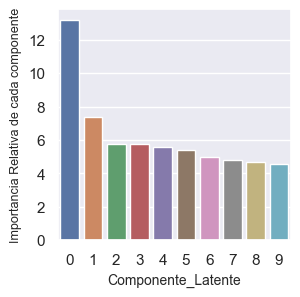

In [29]:
# Gráfica de los Componentes Latentes de la matriz para el análisis de la importancia relativa de cada uno.

sns.set(rc={'figure.figsize':(3,3)})
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()



> Para este punto es importante recalcar que se utilizó la técnica SVD truncada, una técnica matricial que nos ayuda a reducir dimensiones y comprimir datos.

> Unas de sus características clave son que completa datos faltantes, análiza los componentes principales y eficienta el procesamiento de datos. Además nos ayuda a extraer información relevante.

> Por ejemplo, con nuestros resultados y a través de nuestra gráfica de barras podemos observar que, el componente latente 0 con mayor importancia de **13.17320472** supera en más del **55%** al siguiente componente que tiene un puntaje de: **7.37062805**. Mientras que a partir del valor singular 3 hasta el 10 evaluados entre ellos, de denotan una menor diferencia.

Entonces en este punto evaluamos el siguiente aspecto:

**Importancia Relativa vs. Componente Latente**: Los puntajes de los componentes singulares más altos representan componentes más importantes, en este caso, para **0:** 13.17320472 | **1:**7.37062805 | fueron los componentes de mayor importancia, precedidos de los sisguientes: **2:** 5.75839977 | **3:** 5.7403346 | **4:**  5.56044665 | **5:** 5.38941243 | **6:**  4.95123686 | **7:**  4.81108772 | **8:** 4.70087585 | **9:**4.55509817












### **Ejercicio 5**

**Obtener la matriz tokens-temas (*term-topic*) a partir de la matriz $V^T$ de la descomposición SVD.  Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.**  

In [30]:
# La matriz V-transpuesta es la que genera la relación Terms(word)-Topics,
# los renglones son los términos/words y las columnas los tópicos/temas:

lsi_term_topic = V_T

print(lsi_term_topic.shape)

(98256, 10)


In [36]:
# rescatemos los nombres de los términos/tokens:

term_names = list(vectorizer.get_feature_names_out())

print(term_names[:100])

['___guia_de_actuacio', '___tabla_resumen_y_ex', '__luisplanas', '_avt_', '_barallobre', '_deanfuentes', '_gafas_y_reloj_', '_la_epopeya_de_los_pilo', '_miguelhernan', '_obliga', '_vtxo', 'aaas', 'aaimlzvx', 'aaiún', 'aalla', 'aamir', 'aamma', 'aapp', 'aardman', 'aaron', 'aarron', 'aarts', 'aarón', 'abad', 'abades', 'abadeses', 'abadi', 'abadiño', 'abadía', 'abaitua', 'abajo', 'abalanza', 'abalanzamos', 'abalanzaron', 'abalanzándose', 'abalanzó', 'abalos', 'abalosmeco', 'abanca', 'abandera', 'abanderaban', 'abanderada', 'abanderadas', 'abanderado', 'abanderados', 'abanderando', 'abanderar', 'abandere', 'abanderen', 'abanderándose', 'abanderó', 'abandoibarra', 'abandona', 'abandonaba', 'abandonaban', 'abandonada', 'abandonadas', 'abandonado', 'abandonados', 'abandonament', 'abandonamos', 'abandonan', 'abandonando', 'abandonar', 'abandonara', 'abandonaran', 'abandonaremos', 'abandonarla', 'abandonarle', 'abandonarlo', 'abandonarlos', 'abandonaron', 'abandonarse', 'abandonará', 'abandonar

In [32]:
# Y generamos un DataFrame con la matriz term-topic:

term_topic_matrix = pd.DataFrame(data=lsi_term_topic,
                                 index = term_names,
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )

print(term_topic_matrix.shape)   #  words X topics

(98256, 10)


In [33]:
term_topic_matrix.head(5)    # los renglones son los terms/words
                            # y las columnas los conceptos latentes o tópicos:

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
___guia_de_actuacio,0.000137,0.000244,-0.000077,-0.000223,-0.000038,-0.000282,-0.000332,0.000394,-0.000282,-0.000231
___tabla_resumen_y_ex,0.000184,0.000232,-0.000139,-0.000382,-0.000152,-0.000268,-0.000315,0.000897,-0.000360,-0.000627
__luisplanas,0.000033,-0.000071,-0.000024,0.000053,-0.000059,-0.000003,0.000050,-0.000046,-0.000041,-0.000019
_avt_,0.000056,-0.000090,-0.000055,0.000013,-0.000041,0.000051,-0.000104,-0.000010,0.000042,-0.000151
_barallobre,0.000023,-0.000012,-0.000003,-0.000021,0.000017,0.000052,-0.000058,-0.000023,0.000018,-0.000011


Dentro del análisis de los valores singulares de la matriz, se han determinado 10 componentes latentes para el análisis de los term-topic. Con las iteraciones generadas se determinaron 10 coluumnas las cuales son el mejor valor para separar por tópicos o temas los documentos estudiados.

Los valores singulares obtenidos reflejan la factorización de los documentos tokenizados que, para el caso, han determinado dividirse en 10 grandes grupos definidos por los contextos de cada componente. Con esta información se puede determinar cual es la palabra clave o principal para cada una de las columnas generadas; dichos tokens se ordenan de mayor a menor y con su valuación se determinan la frecuencia de las palabras sumado a la temática en la que dicha palabra ha sido utilizada, reflejando el contexto de ello.

Por su parte se muestran los primeros 5 renglones que se describen con el componente latente respectivo y el score que le corresponde a cada uno. A continacuón, en los siguientes puntos se determinarán los detalles de cada componente latente para definir el tópico que recoge la información de dicha organización tales como política, educación, deportes o cualquier tema en particular.


### **Ejercicio 6**

**Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada
uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada uno de
dichos conceptos latentes? ¿Se identifican claramente las temáticas de cada uno de ellos?
.**  

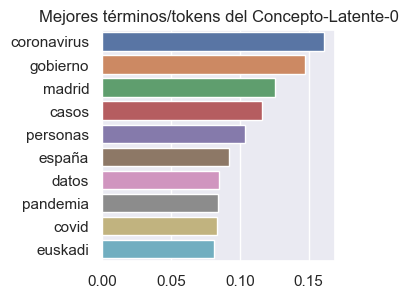

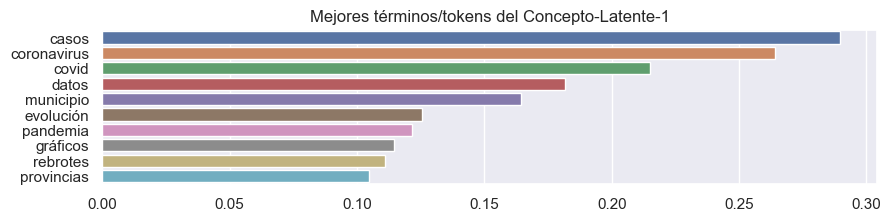

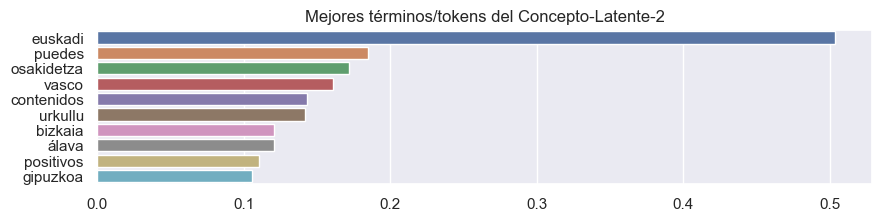

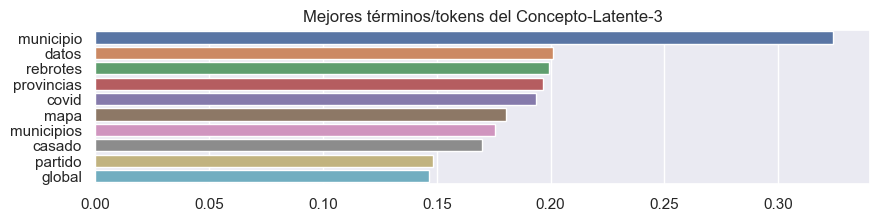

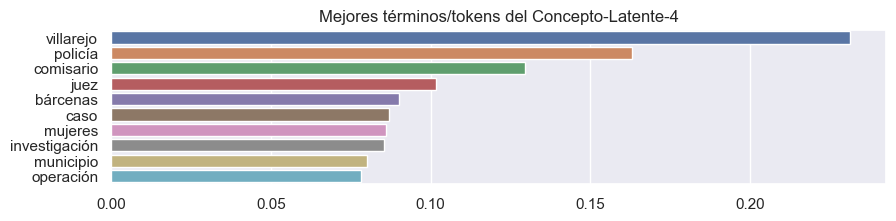

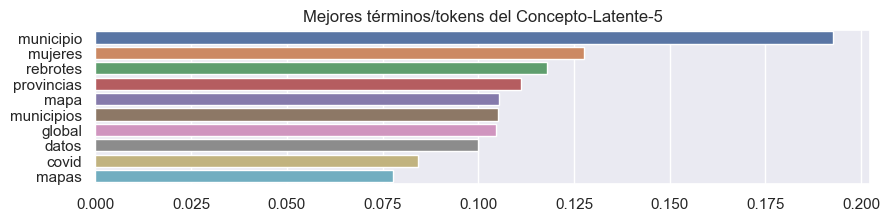

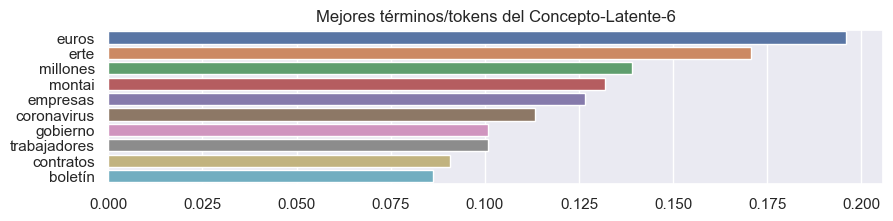

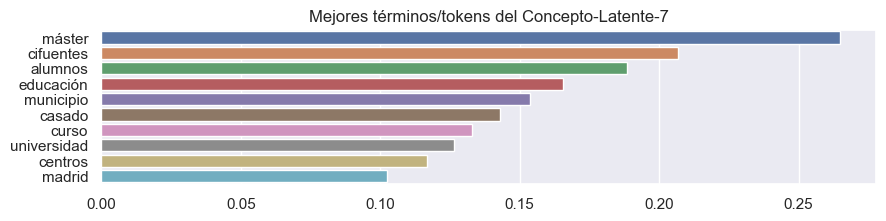

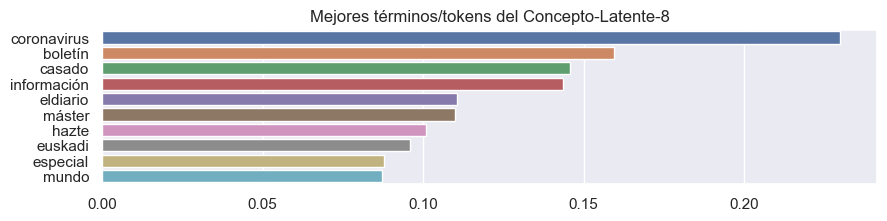

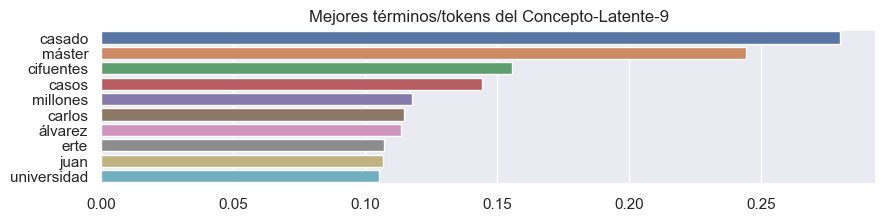

In [34]:
# Seleccionemos por ejemplo una de las columnas/tópico "Concepto_Latente":
for i, key in enumerate(term_topic_matrix):
  data = term_topic_matrix[key]

  # ordenamos lo valores singulares de la columna/tópico de manera descendente.
  data = data.sort_values(ascending=False) # Con la opción True, visualizarás los de menor peso.

  top_w = 10      # Define la cantidad de las mejores "top_w" términos/words a visualizar.
  top_w_matrix = data[:top_w]    # Nos quedamos con los mejores top_w pesos, asociados a
                                # los top_w terms (words).

  # Se grafican cada uno de los componentes latentes reflejando las palabras top de cada uno.
  fig, ax = plt.subplots()
  sns.set(rc={'figure.figsize':(10,2)})
  plt.title(f'Mejores términos/tokens del Concepto-Latente-{i}')
  fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

#### ¿Cómo describirías cada uno de dichos conceptos latentes?

1. **Concepto Latente 0:**
   - **Descripción:** Pandemia del COVID-19 en España
   - **Palabras clave:** Madrid, Euskadi, gobierno, políticas.

2. **Concepto Latente 1:**
   - **Descripción:** Pandemia del COVID-19 en España
   - **Palabras clave:** Rebrotes, provincias, evolución, gráficos.

3. **Concepto Latente 2:**
   - **Descripción:** País Vasco
   - **Palabras clave:** Euskadi, gobierno, políticas.

4. **Concepto Latente 3:**
   - **Descripción:** Pandemia del COVID-19
   - **Palabras clave:** No especificadas, pero relacionadas con la pandemia.

5. **Concepto Latente 4:**
   - **Descripción:** Investigaciones Policiacas Municipales
   - **Palabras clave:** No especificadas, pero relacionadas con investigaciones policiacas.

6. **Concepto Latente 5:**
   - **Descripción:** Pandemia del COVID-19 en Mujeres de España
   - **Palabras clave:** Mujeres, COVID-19, España.

7. **Concepto Latente 6:**
   - **Descripción:** Economía en España
   - **Palabras clave:** Economía, España.

8. **Concepto Latente 7:**
   - **Descripción:** Educación Superior en España
   - **Palabras clave:** Educación, España.

9. **Concepto Latente 8:**
   - **Descripción:** Noticias de España
   - **Palabras clave:** Noticias, España.

10. **Concepto Latente 9:**
    - **Descripción:** Noticias de España
    - **Palabras clave:** Noticias, España.

#### ¿Cuántos tópicos o conceptos latentes identificas con claridad? ¿Cómo los describirías, es decir, de qué temáticas estarían hablando?

Identifico 8 conceptos latentes con claridad:
1. **Pandemia del COVID-19 en España:** Medidas y políticas gubernamentales (Conceptos Latentes 0 y 1).
2. **País Vasco:** Temas regionales relacionados con Euskadi (Concepto Latente 2).
3. **Investigaciones Policiacas Municipales:** Operaciones policiales (Concepto Latente 4).
4. **Pandemia del COVID-19 en Mujeres de España:** Impacto de la pandemia en mujeres (Concepto Latente 5).
5. **Economía en España:** Temas económicos (Concepto Latente 6).
6. **Educación Superior en España:** Temas educativos (Concepto Latente 7).
7. **Noticias de España:** Noticias generales (Conceptos Latentes 8 y 9).

#### Con base a los resultados del ejercicio anterior, ¿cuántos tópicos o conceptos latentes identificas con claridad? ¿Cómo los describirías, es decir, de qué temáticas estarían hablando?

Identifico 8 tópicos o conceptos latentes con claridad, y los describiría de la siguiente manera:

1. **Pandemia del COVID-19 en España:** Medidas y políticas gubernamentales.
2. **Pandemia del COVID-19 en España:** Estudios de rebrotes y evolución de casos.
3. **País Vasco:** Temas regionales en Euskadi.
4. **Pandemia del COVID-19:** Asuntos generales sobre la pandemia.
5. **Investigaciones Policiacas Municipales:** Operaciones y investigaciones policiales.
6. **Pandemia del COVID-19 en Mujeres de España:** Impacto de la pandemia en mujeres.
7. **Economía en España:** Temas económicos relevantes.
8. **Educación Superior en España:** Asuntos relacionados con la educación superior.
9. **Noticias de España:** Noticias generales (combinación de dos tópicos similares).


In [38]:
!pip install gensim

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
     --------------------------------------- 0.0/24.0 MB 393.8 kB/s eta 0:01:01
     --------------------------------------- 0.1/24.0 MB 435.7 kB/s eta 0:00:55
     --------------------------------------- 0.2/24.0 MB 871.5 kB/s eta 0:00:28
      --------------------------------------- 0.4/24.0 MB 1.5 MB/s eta 0:00:16
     - -------------------------------------- 0.6/24.0 MB 2.0 MB/s eta 0:00:12
     - -------------------------------------- 1.2/24.0 MB 3.6 MB/s eta 0:00:07
     -- ------------------------------------- 1.6/24.0 MB 4.3 MB/s eta 0:00:06
     -- ------------------------------------- 1.7/24.0 MB 3.8 MB/s eta 0:00:06
     -- ------------------------------------- 1.7/24.0 MB 3.9 MB/s eta 0:00:06
     -- ------------------------------------- 1.7/24.0 MB 3.9 MB


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import gensim
from gensim import corpora, models
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
documents = df['texto'].tolist()

# Preprocesamos los documentos y creamos un diccionario
preprocessed_documents = [document.lower().split() for document in documents]
#dictionary = corpora.Dictionary(preprocessed_documents)

# Creamos un document-term matrix
#corpus = [dictionary.doc2bow(doc) for doc in preprocessed_documents]

preprocessed_documents[:5][:10]

In [43]:
# Convertimos el DataFrame a una lista de strings
documents = df['texto'].tolist()

# Partimos la lista de strings a una lista de lista de tokens
docs = [document.lower().split() for document in documents]

# Generamos el diccionario
mi_dicc = corpora.Dictionary(docs)

# Generamos la Bag of Words
bow = [mi_dicc.doc2bow(doc) for doc in docs]

In [ ]:
for i in range(2,9):

    lsi = LsiModel(bow,
                   num_topics=i,
                   id2word=mi_dicc,
                   chunksize=1024,
                   random_seed=42
                  )


    cm = CoherenceModel(model=lsi,
                        texts=docs,
                        dictionary=mi_dicc,
                        window_size=3,
                        coherence='c_v',
                        topn = 3
                       )

    cs = cm.get_coherence()

    print('Métrica de Coherencia con {} clusters: {}'.format(i, cs))

In [ ]:
# Seleccionas el mejor de los anteriores:

lsi = LsiModel(bow,
               num_topics=3,
               id2word=mi_dicc,
               chunksize=512,
               random_seed=26
               )

# Veamos la manera en que se distribuyen los términos en cada tópico generado:
for topic_num, words in lsi.print_topics(num_words=4):
    print('Tokens/Words in Topic {}: {}.'.format(topic_num, words))

# **Parte 2: Asignación de Dirichlet Latente (LDA):**

### **Ejercicio 7**

**Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable:**

https://radimrehurek.com/gensim/models/ldamodel.html

https://radimrehurek.com/gensim/models/ldamulticore.html

In [ ]:
# Los documentos a analizar:
docs

# Generamos el diccionario:
id2word = corpora.Dictionary(docs)

for id in range(7):
    print(id2word[id])

In [ ]:
# Generamos el corpus con las tuplas (índice, frecuencia):

corpus = [id2word.doc2bow(doc) for doc in docs]
corpus

In [ ]:
# Siempre podemos expresar cada documento con palabras para un mejor entendimiento:
[[(id2word[id], fre) for id, fre in cor] for cor in corpus[:2]]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                    id2word=id2word,
                    num_topics=4,       # total de tópicos que deseas buscar...
                    chunksize=10,        # número de documentos a analizar en cada chunk de entrenamiento
                    passes=10,          # número de pasadas al corpus durante el entrenamiento.
                    alpha=0.2,          # alfa: similaridad document-topics
                    eta=0.2,            # beta: similaridad topic-words
                    )

In [ ]:
lda_model.print_topics(num_topics=4, num_words=4)

### **Ejercicio 8**

**Con base a esta técnica,**
- **¿qué cantidad de tópicos consideras que es la más adecuada?**
  - La cantidad de tópicos adecuada en LDA puede variar según el corpus y el contexto del análisis. Una forma común de determinar el número óptimo de tópicos es evaluando la coherencia del modelo. La coherencia mide la interpretabilidad de los temas generados y puede ser calculada utilizando la métrica de CoherenceModel en Gensim. En términos generales, la cantidad de tópicos adecuada podría estar entre 5 y 20 para un corpus de tamaño moderado.
  - Número de Tópicos: Inicialmente, se puede probar con 5, 10, 15, 20, etc.
  - Coherencia del Modelo: Calcular la coherencia para cada número de tópicos y elegir el número que maximice la coherencia.

- **¿Qué encuentras de coincidencias y diferencias?**
  - Coincidencias:
    - Ambos métodos buscan reducir la dimensionalidad del corpus y extraer temas latentes.
    - Tanto LDA como LSI pueden proporcionar una distribución de tópicos en documentos y palabras en tópicos.
- Diferencias:
    - LDA:
      - Modelo generativo probabilístico.
      - Asume que los documentos son mezclas de tópicos y que los tópicos son mezclas de palabras.
    - LSI:
      - Basado en álgebra lineal (SVD).
      - Representa los documentos y términos en un espacio de menor dimensión.
      - No es un modelo probabilístico; utiliza reducción de dimensionalidad basada en vectores.
      - Cada documento tiene una distribución de tópicos.
- **¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?**
  - Un número demasiado bajo de tópicos puede agrupar temas distintos en el mismo tópico, mientras que un número demasiado alto puede fragmentar temas coherentes en varios tópicos, esto siempre considerar tanto la coherencia del modelo como la interpretabilidad de los tópicos.

### **Ejercicio 9**

**Incluye tus conclusiones finales de la actividad.**


El modelado de tópicos es una técnica dentro del campo del NLP, que permite descubrir y comprender las temáticas subyacentes en una colección de documentos. El propósito central de este método es reducir un conjunto de documentos en un marco de datos discretos, usualmente mediante una representación en vectores de dichos documentos, donde cada uno corresponde a un conteo de palabras. Una de las suposiciones básicas del modelado de tópicos es que cada documento es una mezcla aleatoria de temáticas y estas, una mezcla de palabras (Kherwa., & Bansal, 2018).

Uno de los modelos algebraicos mediante los cuales se representa un conjunto de documentos (corpus) es el de la frecuencia de término - frecuencia inversa de documento (tf − idf). La premisa de este modelo es que cuanto mayor sea la frecuencia de un término en un documento, más relevante va a ser dicho término para la definición de la temática del respectivo documento (𝑡𝑓).

En complemento, la 𝑖𝑑𝑓 establece que, si un término aparece con mucha frecuencia en muchos documentos, menor será el valor discriminativo de dicho término para la definición de un tópico latente (Asmussen & Møller, 2019).
En esta etapa se realiza la limpieza del corpus y se aplican los procesos de reducción del vocabulario (lematización, stemming, eliminación de stopwords y tokenización).

Posteriormente se redujeron la cantidad de frases y palabras para su análisis dado que se descartaron elementos nada relevantes. Luego se determinó la matriz Tf-idf con la cual se organizó la información de las noticias, determinando en principio la relevancia de ciertos datos. Cada renglón representaba cada uno de los documentos analizados y las columnas representaban todos los tokens del diccionario generado por el método TfidVectorizer.

Los valores obtenidos en las columnas de cada renglón mostraron la importancia que tenía cada token en el documento con relación a la frecuencia total de aparición en todos los documentos analizados. En este caso, para mayor facilidad, se ordenó cada reglón para que se desplegaran sólo las columnas que contienen los 5 tokens de mayor importancia de los primeros 5 documentos.

Implementando el método de descomposición de valores singulares truncado a la matriz Tf-idf con el cual se consideraron 10 valores singulares a considerar cuyos procesos describen el tipo de temas o tópicos que estaban involucrados en el documento analizado. Si bien el modelo mostró varios tipos de contextos diferentes entre sí, se encontraron algunos que podría ser similares a otros llegando incluso a compartir palabras clave que generan redundancia entre los tópicos.

Para esto punto, dependiendo del análisis desarrollado, la cantidad de valores singulares podría reducirse con el fin de tener únicamente contexto distintos y tópicos que no generen reiteración o demasía en su procesamiento. Al momento de graficar la información es visible la granularidad de las palabras clave dentro de cada contexto las cuales, en general, no sobrepasan un 30% de relevancia dentro de cada tópico, con algunas excepciones que si llegan incluso al 50% dentro de su nicho.

En cuanto a los modelos LSI y LDA se observó una reducción en la cantidad de contextos o tópicos que se obtienen en el análisis del documento. Estos módulos contienen incorporados corpus en sus procesamientos facilitando el análisis de los componentes o conjuntos de datps que ayudan a reducir el tamaño de las observaciones, limitando la cantidad de contextos o tópicos involucrados.
Lo anterior permitió obtener tópicos más independientes que acumularan la información de palabras claves en un solo contexto, evitando redundancia o repetición de los mismos elementos.

El modelo de tópicos o temas en particular es un elemento relevante en el procesamiento de lenguaje dado que ayuda en el análisis y direccionamiento de las palabras claves o llamativas dentro de un contexto en particular, el cual puede verse afectado o influenciado por dichas interacciones.


**Bibliografía**


>* Asmussen, C. B., & Møller, C. (2019). Smart literature review: a practical topic modelling approach to exploratory literature review. Journal of Big Data, 6(1), 1-18. https://doi.org/10.1186/s40537-019-0255-7

>* Asuncion, A., Welling, M., Smyth, P., & Teh, Y. W. (2009). On smoothing and inference for topic models. Proceedings of the 25th Conference on Uncertainty in Artificial Intelligence, UAI 2009. (pp. 25-36)

>* Kherwa, P., & Bansal, P. (2018). Topic Modeling: A Comprehensive Review. ICST Transactions on Scalable Information Systems, 7(24). https://doi.org/10.4108/eai.13-7-2018.159623

>* Kowsari, K., Jafari-Meimandi, K., Heidarysafa, M., Mendu, S., Barnes, L., & Brown, D. (2019). Text classification algorithms: A survey. Information, 10(4). https://doi.org/10.3390/info10040150